In [97]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from cvxpy import *
import random
import svt_solver
from sklearn.utils.extmath import randomized_svd, svd_flip
from scipy.sparse.linalg import svds
import pmf_solver
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import scipy.io
import NNM
import Grasscare

In [2]:
mat_data = scipy.io.loadmat('tensor_data.mat')
data = mat_data['inf_adjMat']

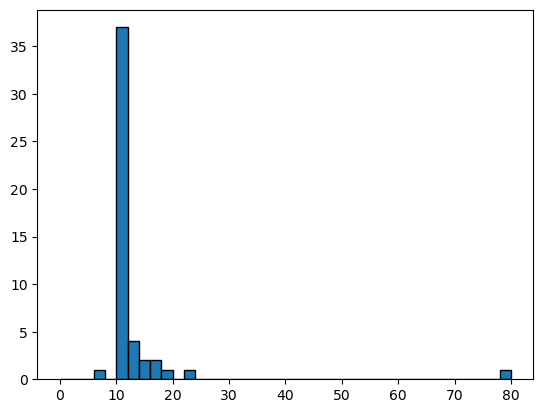

In [4]:
times = []
for i in range(data.shape[0]):
    time_num = data[i][0].shape[2]
    times.append(time_num)
plt.hist(times, bins = np.arange(0,81,2), edgecolor='black')
plt.show()

In [5]:
mean = np.mean(times)
median = np.median(times)
std_dev = np.std(times)
min_val = np.min(times)
max_val = np.max(times)

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)

Mean: 12.571428571428571
Median: 10.0
Standard Deviation: 10.081302151072773
Minimum Value: 6
Maximum Value: 80


In [29]:
dat = []
for i in range(data.shape[0]):
    curr = data[i][0]
    dat.append(curr)

## Functions needed for processing

In [6]:
def plot_heatmap(matrix, subject_index, time_point):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, cmap='YlGnBu', square=True)
    plt.title(f"Missing Pattern Heatmap for Subject {subject_index} at Time Point {time_point}")
    plt.xlabel("ROIs")
    plt.ylabel("ROIs")
    plt.show()

In [46]:
def get_missing_rate(omega):
    count = 0
    flatten = omega.flatten()
    for entry in flatten:
        if entry == 0:
            count += 1
    return count / len(flatten)

In [62]:
def get_omega(X):
    m = X.shape[0]
    n = X.shape[1]
    omega = np.zeros([m,n])
    omega_mask = np.zeros([m,n])
    for i in range(m):
        for j in range(n):
            if np.isnan(X[i][j]):
                omega[i][j] = 0
                omega_mask[i][j] = 0
            else:
                omega[i][j] = X[i][j]
                omega_mask[i][j] = 1
    return omega, omega_mask

def get_omega_list(matrix_list, time):
    omega_list = []
    omega_mask_list = []
    for i in range(time):
        omega, omega_mask = get_omega(matrix_list[:,:,i])
        omega_list.append(omega)
        omega_mask_list.append(omega_mask)
    return omega_list, omega_mask_list

In [66]:
def get_rank(mat_list):
    rank_list = []
    for i in range(len(mat_list)):
        m = mat_list[i]
        rank = np.linalg.matrix_rank(m)
        rank_list.append(rank)
    return rank_list

In [25]:
def get_error(omega_list, omega_mask_list, omega_hat):
    error_list = []
    
    for i in range(len(omega_list)):

        observed_index = np.nonzero(omega_mask_list[i])
        observed_entries = omega_list[i][observed_index]
        completed_entries = omega_hat[i][observed_index]

        error = np.linalg.norm(observed_entries - completed_entries) / np.linalg.norm(observed_entries)
        error_list.append(error)
        
    return error_list

In [94]:
def get_basis(m, rank):
    U,S,V = np.linalg.svd(m)
    b = U[:, 0:rank]
    
    return b

### Subject 1

In [31]:
omega_1, omega_mask_1 = get_omega_list(dat[0], times[0])

In [35]:
sub1_NNM_hat = []
for i in range(len(omega_sub1)):
    sub_hat = NNM.nuclear_norm_solve(omega_1[i], omega_mask_1[i])
    sub1_NNM_hat.append(sub_hat) 

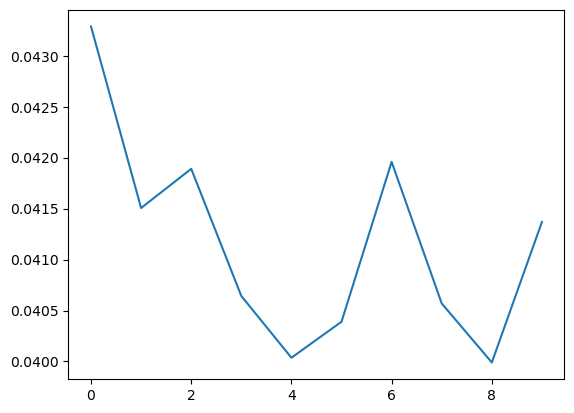

In [36]:
sub1_error = get_error(omega_1, omega_mask_1, sub1_NNM_hat)
plt.plot(range(len(omega_1)), sub1_error)

In [51]:
rank_sub1 = []
for i in range(len(sub1_NNM_hat)):
    m = sub1_NNM_hat[i]
    rank = np.linalg.matrix_rank(m)
    rank_sub1.append(rank)

In [52]:
rank_sub1

[29, 29, 29, 29, 28, 29, 26, 29, 29, 24]

### Subject 2

In [38]:
omega_2, omega_mask_2 = get_omega_list(dat[1], times[1])

In [42]:
sub2_NNM_hat = []
for i in range(len(omega_2)):
    sub_hat = NNM.nuclear_norm_solve(omega_2[i], omega_mask_2[i])
    sub2_NNM_hat.append(sub_hat) 

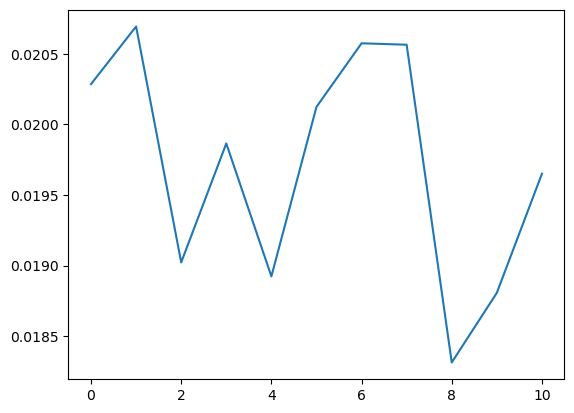

In [43]:
sub2_error = get_error(omega_2, omega_mask_2, sub2_NNM_hat)
plt.plot(range(len(omega_2)), sub2_error)

In [68]:
rank_2 = get_rank(sub2_NNM_hat)

In [69]:
rank_2

[3, 9, 2, 3, 3, 3, 10, 6, 2, 2, 2]

### Ranks of each subject

In [73]:
for i in range(11):
    omega_hat = []
    omega, omega_mask = get_omega_list(dat[i], times[i])
    for j in range(len(omega)):
        sub_hat = NNM.nuclear_norm_solve(omega[j], omega_mask[j])
        omega_hat.append(sub_hat)
    error = get_error(omega, omega_mask, omega_hat)
    rank = get_rank(omega_hat)

    print(f"Subject {i+1}: {rank}")

Subject 1: [29, 29, 29, 29, 28, 29, 26, 29, 29, 24]
Subject 2: [3, 9, 2, 3, 3, 3, 10, 6, 2, 2, 2]
Subject 3: [14, 4, 4, 11, 4, 4, 5, 7, 6, 4]
Subject 4: [30, 30, 31, 31, 31, 31, 30, 31, 29, 31]
Subject 5: [37, 37, 37, 37, 37, 37, 37, 37, 37, 37]
Subject 6: [38, 37, 38, 38, 37, 38, 37, 38, 38, 38]
Subject 7: [29, 29, 29, 24, 28, 28, 29, 27, 27, 25]
Subject 8: [25, 22, 22, 21, 23, 22, 18, 25, 9, 24]
Subject 9: [29, 31, 31, 31, 31, 31, 31, 28, 31, 30, 31, 31, 31]
Subject 10: [4, 14, 14, 5, 3, 15, 7, 5, 14, 3]
Subject 11: [6, 5, 7, 11, 5, 6, 17, 11, 5, 6, 15, 7, 6]


In [83]:
for i in range(11,20):
    omega_hat = []
    omega, omega_mask = get_omega_list(dat[i], times[i])
    for j in range(len(omega)):
        sub_hat = NNM.nuclear_norm_solve(omega[j], omega_mask[j])
        omega_hat.append(sub_hat)
    error = get_error(omega, omega_mask, omega_hat)
    rank = get_rank(omega_hat)

    print(f"Subject {i+1}: {rank}")

Subject 12: [35, 34, 35, 35, 35, 35, 35, 35, 35, 35]
Subject 13: [8, 7, 13, 19, 6, 21, 15, 18, 7, 17]
Subject 14: [34, 33, 34, 33, 34, 34, 33, 33, 34, 34]
Subject 15: [26, 25, 26, 27, 26, 28, 28, 26, 27, 28]
Subject 16: [35, 34, 35, 35, 33, 35, 35, 35, 35, 35]
Subject 17: [31, 31, 31, 31, 31, 31]
Subject 18: [39, 39, 39, 38, 39, 38, 38, 38, 39, 39]
Subject 19: [36, 36, 36, 36, 36, 36, 35, 36, 36, 36]
Subject 20: [43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]


In [84]:
for i in range(20,30):
    omega_hat = []
    omega, omega_mask = get_omega_list(dat[i], times[i])
    for j in range(len(omega)):
        sub_hat = NNM.nuclear_norm_solve(omega[j], omega_mask[j])
        omega_hat.append(sub_hat)
    error = get_error(omega, omega_mask, omega_hat)
    rank = get_rank(omega_hat)

    print(f"Subject {i+1}: {rank}")

Subject 21: [31, 32, 31, 31, 32, 32, 32, 32, 32, 32, 32, 31]
Subject 22: [29, 30, 30, 30, 30, 29, 30, 30, 30, 27, 29, 30, 30, 29, 30, 29, 30]
Subject 23: [37, 37, 37, 37, 37, 36, 37, 37, 37, 37]
Subject 24: [34, 35, 35, 35, 35, 35, 35, 34, 35, 35]
Subject 25: [7, 10, 23, 23, 22, 9, 21, 21, 22, 19, 20, 20, 9, 23, 20]
Subject 26: [31, 32, 31, 32, 31, 32, 29, 32, 29, 32]
Subject 27: [40, 41, 41, 41, 41, 41, 41, 41, 41, 41]
Subject 28: [31, 31, 30, 31, 31, 30, 31, 30, 22, 31]
Subject 29: [33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 33]
Subject 30: [38, 38, 38, 38, 38, 38, 38, 38, 38, 38]


In [85]:
for i in range(30,40):
    omega_hat = []
    omega, omega_mask = get_omega_list(dat[i], times[i])
    for j in range(len(omega)):
        sub_hat = NNM.nuclear_norm_solve(omega[j], omega_mask[j])
        omega_hat.append(sub_hat)
    error = get_error(omega, omega_mask, omega_hat)
    rank = get_rank(omega_hat)

    print(f"Subject {i+1}: {rank}")

Subject 31: [5, 4, 4, 3, 3, 3, 3, 3, 3, 3]
Subject 32: [29, 27, 28, 29, 27, 27, 26, 29, 28, 28]
Subject 33: [37, 37, 37, 37, 37, 37, 37, 37, 36, 37]
Subject 34: [17, 15, 15, 6, 8, 5, 6, 3, 4, 16, 17, 13, 17, 15, 11]
Subject 35: [23, 14, 9, 17, 20, 8, 22, 16, 22, 7, 24, 23, 24, 19, 21, 18, 15, 24, 20, 24, 19, 23, 24, 21, 16, 23, 19, 24, 24, 20, 19, 18, 24, 22, 15, 24, 22, 23, 18, 22, 23, 22, 16, 11, 24, 22, 23, 19, 6, 7, 23, 22, 7, 19, 16, 16, 9, 22, 23, 16, 12, 16, 22, 24, 9, 17, 21, 22, 23, 22, 20, 18, 24, 23, 21, 20, 24, 22, 18, 23]
Subject 36: [33, 34, 34, 34, 34, 33, 33, 32, 34, 34, 33]
Subject 37: [31, 32, 32, 31, 31, 32, 32, 30, 31, 32, 31, 31, 32, 32, 32, 32, 32, 32]
Subject 38: [31, 31, 30, 31, 29, 31, 31, 31, 31, 18]
Subject 39: [26, 28, 23, 25, 27, 24, 26, 26, 23, 24]
Subject 40: [16, 9, 13, 17, 15, 6, 20, 20, 12, 17]


In [86]:
for i in range(40,49):
    omega_hat = []
    omega, omega_mask = get_omega_list(dat[i], times[i])
    for j in range(len(omega)):
        sub_hat = NNM.nuclear_norm_solve(omega[j], omega_mask[j])
        omega_hat.append(sub_hat)
    error = get_error(omega, omega_mask, omega_hat)
    rank = get_rank(omega_hat)

    print(f"Subject {i+1}: {rank}")

Subject 41: [31, 33, 33, 33, 33, 33, 33, 32, 33, 33]
Subject 42: [35, 35, 34, 35, 35, 35, 35, 35, 35, 35, 35]
Subject 43: [22, 18, 22, 16, 21, 7, 23, 22, 14, 12, 19, 23, 21, 21, 22, 22, 8]
Subject 44: [23, 23, 21, 11, 20, 10, 22, 22, 20, 22, 23, 22, 18, 22, 21, 5, 15, 22, 17, 22, 16, 23]
Subject 45: [11, 8, 17, 13, 7, 11, 20, 20, 19, 13]
Subject 46: [38, 38, 38, 38, 38, 38, 38, 38, 38, 38]
Subject 47: [25, 10, 18, 20, 17, 23, 24, 19, 26, 26, 26]
Subject 48: [17, 22, 14, 12, 25, 10, 21, 25, 21, 25, 25, 22]
Subject 49: [22, 7, 16, 15, 21, 17, 21, 20, 12, 14]


In [95]:
omega_hat_1 = []
b1 = []
omega, omega_mask = get_omega_list(dat[0], times[0])
for j in range(len(omega)):
    sub_hat = NNM.nuclear_norm_solve(omega[j], omega_mask[j])
    omega_hat_1.append(sub_hat)
    
    b = get_basis(sub_hat, 3)
    b1.append(b)

In [100]:
b1 = np.array(b1)

In [101]:
Grasscare.grasscare(b1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.